# Build a model on experimental data using mofdscribe


In [ ]:
!pip install mofdscribe sklearn pymatviz rdkit

In [4]:
import pandas as pd

from scipy.stats.stats import pearsonr

import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import HistGradientBoostingRegressor

from pymatgen.core import Structure

from pymatviz.parity import density_scatter_with_hist

from mofdscribe.featurizers.chemistry import APRDF, RACS, AMD
from mofdscribe.featurizers.base import MOFMultipleFeaturizer
from mofdscribe.datasets.thermal_stability_dataset import ThermalStabilityDataset
from mofdscribe.datasets.structuredataset import FrameDataset
from mofdscribe.splitters import HashSplitter

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_56112/499758782.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


## Compile the starting data


For convenience, we will start using the `ThermalStabilityDataset` in `mofdscribe` which contains thermal decomposition temperatures of MOFs curated by [Nandy et al.](https://www.nature.com/articles/s41597-022-01181-0). In this notebook, we will only use the structures and labels from this class and then featurize it using the `RACS` and `APRDF` featurizers.

Note that this step already drops some duplicates (but this would automatically happen once you create a `mofdscribe` dataset).


In [62]:
dataset = ThermalStabilityDataset()

2022-12-16 18:45:10.443 | DEBUG    | mofdscribe.datasets.thermal_stability_dataset:__init__:115 - Dropped 86 duplicate basenames. New length 1953
2022-12-16 18:45:10.485 | DEBUG    | mofdscribe.datasets.thermal_stability_dataset:__init__:121 - Dropped 197 duplicate graphs. New length 1756


In [63]:
len(dataset)

1756

Let's load the structures as pymatgen objects into memory. To save time, we will only use a part of the dataset. If you find it too slow for playing around, go ahead and reduce this number.?


In [64]:
num_structures = 1500

In [65]:
all_structures = dataset.get_structures(range(num_structures))

Now, let's also extract the labels


In [66]:
y = dataset.get_labels(range(num_structures)).flatten()

In [67]:
assert len(all_structures) == len(y)

## Featurize the structures


We will use the `MOFMultipleFeaturizer` to featurize the structures. This class allows to featurize multiple structures at once, which is much faster than featurizing each structure individually since, for example, we only need to compute the primitive cells once.


In [68]:
featurizer = MOFMultipleFeaturizer([APRDF(), RACS(), AMD()])

In [69]:
featurizer.set_n_jobs(3)  # Use 3 cores

In [70]:
feats = featurizer.featurize_many(
    all_structures, ignore_errors=True
)  # we ignore errors here because some structures might not be fragmentable, those will then have NaNs in the feature matrix

2022-12-16 18:47:24.757 | DEBUG    | mofdscribe.featurizers.base:featurize_many:232 - Precomputing primitive cells


MOFMultipleFeaturizer:   0%|          | 0/1500 [00:00<?, ?it/s]

2022-12-16 18:48:20.867 | DEBUG    | mofdscribe.featurizers.base:featurize:103 - Featurizing structure in MOFBaseFeaturizer
2022-12-16 18:48:20.870 | WARNING  | element_coder.data.coding_data:get_coding_dict:85 - This coding is not unique for certain elements. This will cause problems when decoding.
2022-12-16 18:48:20.870 | WARNING  | element_coder.data.coding_data:get_coding_dict:85 - This coding is not unique for certain elements. This will cause problems when decoding.
2022-12-16 18:48:21.003 | DEBUG    | mofdscribe.featurizers.base:featurize:103 - Featurizing structure in MOFBaseFeaturizer
2022-12-16 18:48:21.004 | WARNING  | element_coder.data.coding_data:get_coding_dict:85 - This coding is not unique for certain elements. This will cause problems when decoding.
2022-12-16 18:48:21.004 | WARNING  | element_coder.data.coding_data:get_coding_dict:85 - This coding is not unique for certain elements. This will cause problems when decoding.
2022-12-16 18:48:21.269 | DEBUG    | mofdscr

In [71]:
len(feats)

1500

## Explore the dataset


In [72]:
X_decomposed = PCA(n_components=2).fit_transform(
    StandardScaler().fit_transform(np.nan_to_num(feats, 0))
)

In [73]:
len(X_decomposed)

1500

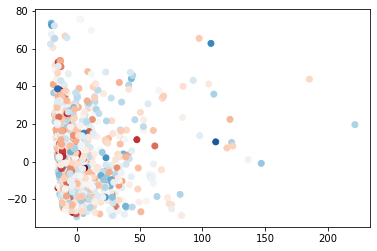

In [74]:
plt.scatter(X_decomposed[:, 0], X_decomposed[:, 1], c=y, cmap="RdBu_r")

Let's look at the correlation between the features and the labels.


In [75]:
X_df = pd.DataFrame(feats, columns=featurizer.feature_labels())

In [76]:
y_df = pd.DataFrame(y, columns=["Tg"])

In [77]:
pd.concat([X_df, y_df], axis=1).corr("pearson")["Tg"].abs().sort_values(ascending=False)

Tg                                                                             1.000000
racs_bb-nodes_prop-X_scope-3_propagg-diff_corragg-avg_bbagg-avg                0.397377
racs_bb-nodes_prop-X_scope-1_propagg-diff_corragg-avg_bbagg-avg                0.385261
racs_bb-nodes_prop-X_scope-2_propagg-product_corragg-avg_bbagg-avg             0.330157
racs_bb-linker_connecting_prop-X_scope-1_propagg-diff_corragg-avg_bbagg-avg    0.322769
                                                                                 ...   
racs_bb-nodes_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum                     NaN
racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-avg_bbagg-avg                     NaN
racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-avg_bbagg-sum                     NaN
racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-avg                     NaN
racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum                     NaN
Name: Tg, Length: 2113, dtype: f

In [78]:
pd.concat([X_df, y_df], axis=1).corr("spearman")["Tg"].abs().sort_values(ascending=False)

Tg                                                                             1.000000
racs_bb-nodes_prop-X_scope-3_propagg-diff_corragg-avg_bbagg-avg                0.400738
racs_bb-nodes_prop-X_scope-1_propagg-diff_corragg-avg_bbagg-avg                0.398862
racs_bb-nodes_prop-X_scope-2_propagg-product_corragg-avg_bbagg-avg             0.364650
racs_bb-linker_connecting_prop-X_scope-1_propagg-diff_corragg-avg_bbagg-avg    0.352490
                                                                                 ...   
racs_bb-nodes_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum                     NaN
racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-avg_bbagg-avg                     NaN
racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-avg_bbagg-sum                     NaN
racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-avg                     NaN
racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum                     NaN
Name: Tg, Length: 2113, dtype: f

## Build and test a model using mofdscribe


To showcase how we can use the splitters in MOFdscribe, we will build a new dataset.


For convenience, we will extract some metadata from the old dataset.


In [79]:
meta_df = dataset._df.iloc[range(num_structures)][
    ["info.CoRE_name", "info.year", "info.undecorated_scaffold_hash"]
]

In [82]:
full_df = pd.concat([meta_df, X_df, y_df], axis=1).fillna(0)

Let's check the documentation of the `FrameDataset` class to see what we can do with it.


In [83]:
?FrameDataset

Init signature:
FrameDataset(
    df: pandas.core.frame.DataFrame,
    structure_name_column: str,
    year_column: Union[str, NoneType] = None,
    label_columns: Union[List[str], NoneType] = None,
    decorated_graph_hash_column: Union[str, NoneType] = None,
    undecorated_graph_hash_column: Union[str, NoneType] = None,
    decorated_scaffold_hash_column: Union[str, NoneType] = None,
    undecorated_scaffold_hash_column: Union[str, NoneType] = None,
    density_column: Union[str, NoneType] = None,
)
Docstring:      Dataset containing structure information read from a dataframe.
Init docstring:
Initialize the dataset.

Args:
    df (pd.DataFrame): Dataframe containing the structures.
    structure_name_column (str): Name of the column containing the structure names.
    year_column (str, optional): Name of the column containing the year of the structure.
        Defaults to None.
    label_columns (Optional[List[str]], optional): List of columns containing the labels.
        Default

In [84]:
my_dataset = FrameDataset(
    df=full_df,
    structure_name_column="info.CoRE_name",
    year_column="info.year",
    undecorated_scaffold_hash_column="info.undecorated_scaffold_hash",
    label_columns=["Tg"],
)

2022-12-17 12:11:58.487 | WARNING  | mofdscribe.datasets.structuredataset:__init__:215 - FrameDataset support is experimental. Some splitter integrations may not work.


In [85]:
train_idx, test_idx = HashSplitter(my_dataset).train_test_split(frac_train=0.8)

2022-12-17 12:12:01.288 | DEBUG    | mofdscribe.splitters.splitters:__init__:116 - Splitter settings | shuffle True, random state None, sample frac 1.0, q (0, 0.25, 0.5, 0.75, 1)
2022-12-17 12:12:01.289 | DEBUG    | mofdscribe.splitters.utils:check_fraction:429 - Using fractions: train: 0.8, valid: 0, test: 0.19999999999999996
2022-12-17 12:12:01.290 | DEBUG    | mofdscribe.splitters.splitters:train_test_split:159 - Using grouped partition


In [86]:
X_train, y_train = (
    my_dataset._df[featurizer.feature_labels()].values[train_idx],
    my_dataset._df["Tg"].values[train_idx],
)
X_test, y_test = (
    my_dataset._df[featurizer.feature_labels()].values[test_idx],
    my_dataset._df["Tg"].values[test_idx],
)

In [87]:
regressor = HistGradientBoostingRegressor(max_iter=1000)
regressor.fit(X_train, y_train)

HistGradientBoostingRegressor(max_iter=1000)

In [88]:
predictions = regressor.predict(X_test)

<AxesSubplot:xlabel='Predicted Tg', ylabel='Actual Tg'>

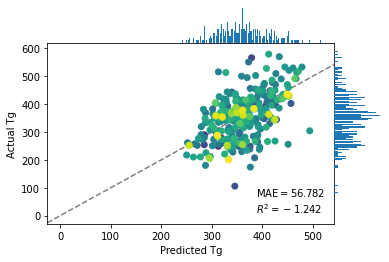

In [89]:
density_scatter_with_hist(predictions, y_test, xlabel="Predicted Tg", ylabel="Actual Tg")

Using the full dataset (and a different feature set, model, and splitting strategy) the [original paper](https://pubs.acs.org/doi/full/10.1021/jacs.1c07217) reported an error in the same order of magnitude (44 C), but notably better than the one we get here.


## Tuning the model


If you want to tune the model, i.e., perform hyperparameter search you might want to use a flavor of $k$-fold cross validation.
The `k_fold` methods of the splitters return a generator of train and test indices -- similar to the `split` method of the [`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) object in `sklearn`. You should therefore be able to use them interchangeably.


In [95]:
param_grid = {
    "max_iter": [100, 200, 500],
    "max_depth": [3, 5, 10, 20],
}

It is often to create a new subset dataset as this makes sure that there is no trace of test data in the dataset object.

In [96]:
train_set = my_dataset.get_subset(train_idx)

2022-12-17 16:04:46.714 | WARNING  | mofdscribe.datasets.structuredataset:__init__:215 - FrameDataset support is experimental. Some splitter integrations may not work.


In [97]:
splitter = HashSplitter(train_set)

2022-12-17 16:04:47.057 | DEBUG    | mofdscribe.splitters.splitters:__init__:116 - Splitter settings | shuffle True, random state None, sample frac 1.0, q (0, 0.25, 0.5, 0.75, 1)


In [100]:
cv = GridSearchCV(
    HistGradientBoostingRegressor(),
    param_grid,
    cv=splitter.k_fold(),
    n_jobs=5,
    verbose=1,
    scoring="neg_mean_absolute_error",
)

In [101]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=<generator object BaseSplitter.k_fold at 0x2a186c040>,
             estimator=HistGradientBoostingRegressor(), n_jobs=5,
             param_grid={'max_depth': [3, 5, 10, 20],
                         'max_iter': [100, 200, 500]},
             scoring='neg_mean_absolute_error', verbose=1)

In [102]:
model = cv.best_estimator_

In [106]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

<AxesSubplot:xlabel='Predicted Tg', ylabel='Actual Tg'>

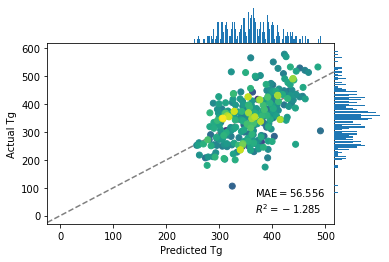

In [107]:
density_scatter_with_hist(predictions, y_test, xlabel="Predicted Tg", ylabel="Actual Tg")